# 09. PyTorch Model Deployment

What is model deployment?

Machine learning model deployment is the act of making your machine learning model(s) available to someone or something else


## Resources

Link: https://www.learnpytorch.io/09_pytorch_model_deployment/

## 0. Get setup

In [1]:
import torch
import torchvision

from torch import nn
from torchinfo import summary

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from src import setup_data, get_data, helper_functions, utils, engine, predictions

In [2]:
device = "cuda" if torch.cuda.is_available() else (
    "mps" if torch.mps.is_available() else "cpu"
)

device

'mps'

## 1. Geting data

The dataset we're going to use for deploying a FoodVision Mini model is...

Pizza, steak, sushi 20% dataset (pizza steak, sushi, classes from Food101, random 20% samples)

In [3]:
get_data.get_data(data_dir_str="data/",
                                         image_path_str="pizza_steak_sushi_20_percent",
                                         data_url_str="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                         file_name_str="pizza_steak_sushi_20_percent.zip")

data/pizza_steak_sushi_20_percent exists...
Data in data/pizza_steak_sushi_20_percent already exits, skipping downloading and unzipping...
Finished getting data...


In [4]:
# Setup training and testing paths
from pathlib import Path

train_dir = Path("data") / "pizza_steak_sushi_20_percent" / "train"
test_dir = Path("data") / "pizza_steak_sushi_20_percent" / "test"

In [5]:
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

## 2. FoodVision Mini model deployment experiment outline

### 3 questions:
1. What is my most ideal machine learning model deployment scenario?
2. Where is my model going to go?
3. How is my model going to function?

**FoodVision Mini ideal use case:** a model that performs well and fast

1. Performs well: 95%+ accuracy
2. Performs fast: as close to real-time (or faster) as possible (30FPS+ or 30ms latency)
    * Lateny = time for prediction to take place

To try and achieve these goals, we're going to build two models experiments:
1. EffNetB2 feature extractor (just like in 07. PyTorch Experiment Tracking)
2. ViT feature extractor (just like in 08. PyTorch Paper Replicating)

## 3. Creating an EffNetB2 feature extractor

Feature extractor = a term for a transfer learning model that has its base layers frozen and outpul layers (or head layers) frozen to a certain problem

In [13]:
# 1. Setup pretrained EffNetB2 weights
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT

# 2. Get EffNetB2 transforms
effnetb2_transforms = effnetb2_weights.transforms()

# 3. Setup pretrained model instance
effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights).to(device)

# 4. Freeze base layeres in the model (this will stop all layers from training)
for param in effnetb2.parameters():
    param.requires_grad = False

In [14]:
summary(effnetb2,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   False
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16,

In [10]:
effnetb2.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [15]:
torch.manual_seed(42)
effnetb2.classifier = nn.Sequential(nn.Dropout(p=0.3, inplace=True),
                                    nn.Linear(in_features=1408, out_features=3, bias=True)).to(device)

In [16]:
summary(effnetb2,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

### 3.1 Creating a function to make an EffNetB2 feature extractor

In [17]:
def create_effnetb2_model(num_classes:int=3):
    # 1. Setup pretrained EffNetB2 weights
    effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT

    # 2. Get EffNetB2 transforms
    effnetb2_transforms = effnetb2_weights.transforms()

    # 3. Setup pretrained model instance
    effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights).to(device)

    # 4. Freeze base layeres in the model (this will stop all layers from training)
    for param in effnetb2.parameters():
        param.requires_grad = False
    
    # 5. Change classifier head with random seef for repoducibility
    torch.manual_seed(42)
    
    effnetb2.classifier = nn.Sequential(nn.Dropout(p=0.3, inplace=True),
                                        nn.Linear(in_features=1408, out_features=num_classes, bias=True)).to(device)
    
    return effnetb2, effnetb2_transforms

In [18]:
effnetb2, effnetb2_transforms = create_effnetb2_model()

In [20]:
effnetb2_transforms

ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [19]:
effnetb2

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

### 3.2 Creating DataLoaders for EffNetB2

In [21]:
# Setup DataLoaders
train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = setup_data.create_dataloaders(train_dir=train_dir,
                                                                                                 test_dir=test_dir,
                                                                                                 batch_size=32,
                                                                                                 transform=effnetb2_transforms)

In [22]:
len(train_dataloader_effnetb2), len(test_dataloader_effnetb2), class_names

(15, 5, ['pizza', 'steak', 'sushi'])

### 3.3 Training EffNetB2 feature extractor

In [24]:
# Loss function
loss_fn = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(params=effnetb2.parameters(),
                             lr=1e-3)

loss_fn, optimizer

(CrossEntropyLoss(),
 Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     decoupled_weight_decay: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: None
     lr: 0.001
     maximize: False
     weight_decay: 0
 ))

In [25]:
# Training function
torch.manual_seed(42)

effnet_b2_results = engine.train(model=effnetb2,
                                 train_dataloader=train_dataloader_effnetb2,
                                 test_dataloader=test_dataloader_effnetb2,
                                 epochs=10,
                                 optimizer=optimizer,
                                 loss_fn=loss_fn,
                                 device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

/Users/mchojna/Documents/GitHub/pytorch-course/.venv/lib/python3.13/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch: 1 | train_loss: 0.9817 | train_acc: 0.5729 | test_loss: 0.7343 | test_acc: 0.9625
Epoch: 2 | train_loss: 0.7070 | train_acc: 0.8667 | test_loss: 0.5739 | test_acc: 0.9500
Epoch: 3 | train_loss: 0.6039 | train_acc: 0.8167 | test_loss: 0.4819 | test_acc: 0.9625
Epoch: 4 | train_loss: 0.4490 | train_acc: 0.9021 | test_loss: 0.4318 | test_acc: 0.9375
Epoch: 5 | train_loss: 0.4287 | train_acc: 0.9104 | test_loss: 0.3894 | test_acc: 0.9472
Epoch: 6 | train_loss: 0.4202 | train_acc: 0.8833 | test_loss: 0.3528 | test_acc: 0.9688
Epoch: 7 | train_loss: 0.4224 | train_acc: 0.8396 | test_loss: 0.3256 | test_acc: 0.9472
Epoch: 8 | train_loss: 0.3951 | train_acc: 0.8875 | test_loss: 0.3461 | test_acc: 0.9472
Epoch: 9 | train_loss: 0.3832 | train_acc: 0.8771 | test_loss: 0.3104 | test_acc: 0.9347
Epoch: 10 | train_loss: 0.3655 | train_acc: 0.8604 | test_loss: 0.2837 | test_acc: 0.9625


### 3.4 Inspect EffNetB2 loss curves

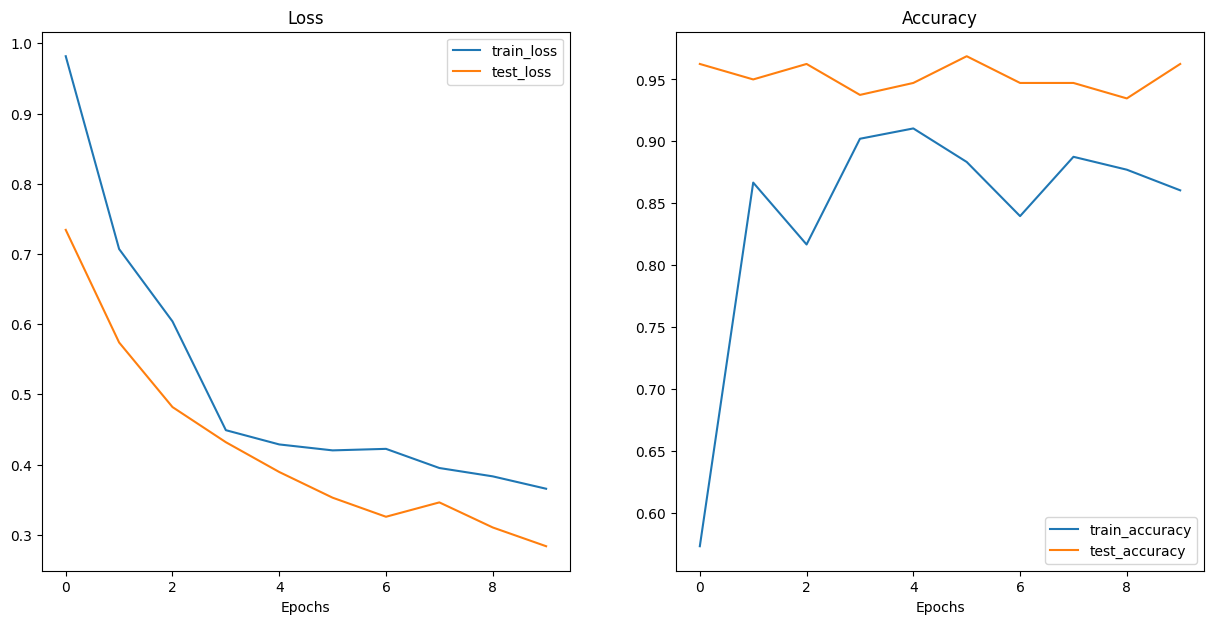

In [26]:
helper_functions.plot_loss_curves(effnet_b2_results)

### 3.5 Saving EffNetB2 feature extractor

In [27]:
utils.save_model(model=effnetb2,
                 target_dir="models",
                 model_name="09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth


### 3.6 Inspecting size of EffNetB2 feature extractor

Why would it be important to consider the size of a saved model?

If we're deploying our model to be used on a mobile app/website, there may be limited compute resouces

So if our model file is too large, we may not be able to store / run it on our target device

In [28]:
from pathlib import Path

# Get the model size in bytes and convert to megabytes
pretrained_effnetb2_model_size = Path("models/09_pretrained_effnetb2_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size / (1024 * 1024)
print(f"Pretrained EffNetB2 feature extractor model size: {round(pretrained_effnetb2_model_size, 2)} MB")

Pretrained EffNetB2 feature extractor model size: 29.86 MB


### 3.7 Collecting EffNetB2 feature extractor stats

In [29]:
# Count number of parameters in EffNetB2
effnetb2_total_params = sum(torch.numel(param) for param in effnetb2.parameters())
effnetb2_total_params

7705221

In [31]:
# Create a dictionary with EffNetB2 statistics
effnetb2_stats = {"test_loss": effnet_b2_results["test_loss"][-1],
                  "test_acc": effnet_b2_results["test_acc"][-1],
                  "number_of_parameters": effnetb2_total_params,
                  "model_size (MB)": pretrained_effnetb2_model_size}

effnetb2_stats

{'test_loss': 0.28366082310676577,
 'test_acc': 0.9625,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29.8577299118042}

## 4. Creating a ViT feature extractor

We're up to our second modelling experiment, repeating the steps for EffNetB2 but this time with a ViT feature extractor, see here for ideas

In [32]:
# Check out the ViT heads layer
vit = torchvision.models.vit_b_16()
vit.heads

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

In [ ]:
def create_vit_model(num_classes:int=3):
    # Create ViT_B_16 pretrained weights, transforms and model
    weights = torchvision.models.ViT_B_16_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.vit_b_16(weights=weights)

    # Freeze all of the base layers
    for param in model.parameters():
        param.requires_grad = False

    # Change classifier head to suit our needs
    torch.manual_seed(42)
    model.heads = nn.Sequential(nn.Linear(in_features=768, 
                                          out_features=num_classes))

    return model, transforms

In [57]:
vit, vit_transforms = create_vit_model()
vit_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [58]:
summary(vit, 
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

### 4.1 Create DataLoaders for ViT feature extractor

In [59]:
train_dataloader_vit, test_dataloader_vit, class_names = setup_data.create_dataloaders(train_dir=train_dir,
                                                                                       test_dir=test_dir,
                                                                                       transform=vit_transforms,
                                                                                       batch_size=32)
len(train_dataloader_vit), len(test_dataloader_vit), class_names

(15, 5, ['pizza', 'steak', 'sushi'])

### 4.2 Training ViT Feature Extractor

We're up to model experiment number two: a ViT feature extractor.

In [60]:
# Setup optimizer 
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=1e-3)

# Setup loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Train ViT feature extractor with seeds set for reproducibility
torch.manual_seed(42)
vit_results = engine.train(model=vit,
                           train_dataloader=train_dataloader_vit,
                           test_dataloader=test_dataloader_vit,
                           epochs=10,
                           optimizer=optimizer,
                           loss_fn=loss_fn,
                           device="cpu")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7020 | train_acc: 0.7521 | test_loss: 0.2714 | test_acc: 0.9381
Epoch: 2 | train_loss: 0.2532 | train_acc: 0.9062 | test_loss: 0.1672 | test_acc: 0.9602
Epoch: 3 | train_loss: 0.1764 | train_acc: 0.9542 | test_loss: 0.1273 | test_acc: 0.9693
Epoch: 4 | train_loss: 0.1276 | train_acc: 0.9625 | test_loss: 0.1074 | test_acc: 0.9722
Epoch: 5 | train_loss: 0.1159 | train_acc: 0.9646 | test_loss: 0.0953 | test_acc: 0.9784
Epoch: 6 | train_loss: 0.1274 | train_acc: 0.9375 | test_loss: 0.0832 | test_acc: 0.9722
Epoch: 7 | train_loss: 0.0897 | train_acc: 0.9771 | test_loss: 0.0845 | test_acc: 0.9784
Epoch: 8 | train_loss: 0.0919 | train_acc: 0.9812 | test_loss: 0.0764 | test_acc: 0.9722
Epoch: 9 | train_loss: 0.0922 | train_acc: 0.9792 | test_loss: 0.0734 | test_acc: 0.9784
Epoch: 10 | train_loss: 0.0658 | train_acc: 0.9833 | test_loss: 0.0644 | test_acc: 0.9847


### 4.3 Plot loss curves of ViT feature extractor

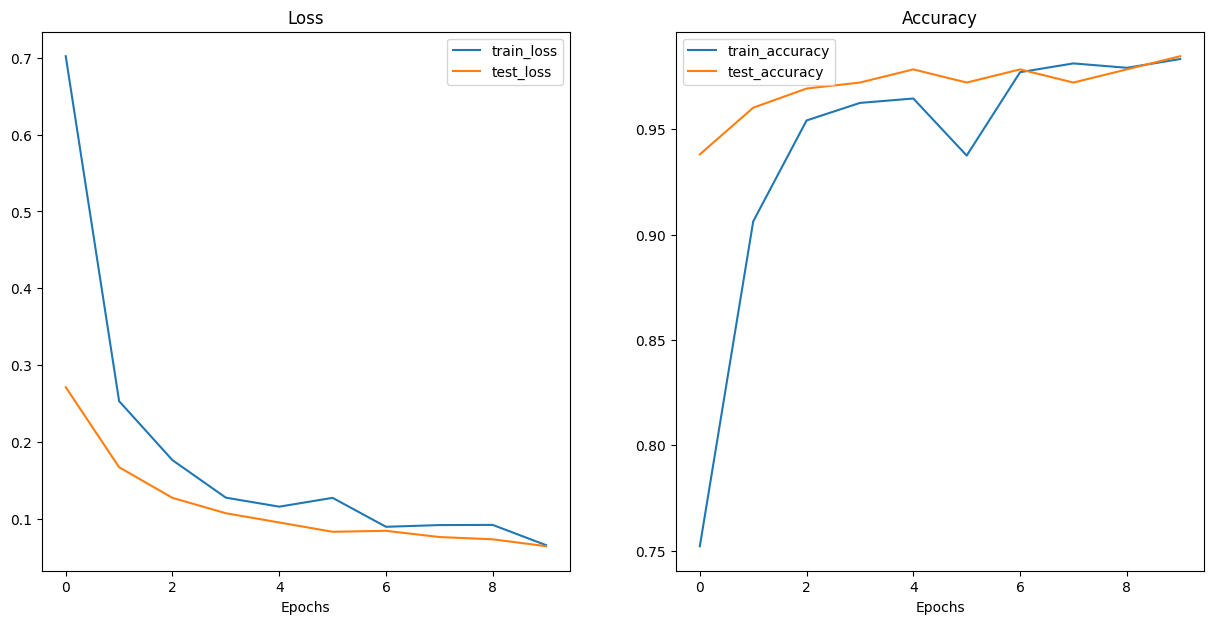

In [69]:
helper_functions.plot_loss_curves(vit_results)

### 4.4 Saving ViT feature extractor

In [70]:
utils.save_model(model=vit,
                 target_dir="models",
                 model_name="09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models/09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth


### 4.5 Checking the size of ViT feature extractor


In [71]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_vit_model_size = Path("models/09_pretrained_vit_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size / (1024*1024)
print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")

Pretrained ViT feature extractor model size: 327.36950397491455 MB


### 4.6 Collecting ViT feature extractor stats

In [72]:
# Count number of parameters in ViT 
vit_total_params = sum(torch.numel(param) for param in vit.parameters())
vit_total_params

85800963

In [73]:
# Create ViT statistics dictionary
vit_stats = {"test_loss": vit_results["test_loss"][-1],
             "test_acc": vit_results["test_acc"][-1],
             "number_of_parameters": vit_total_params,
             "model_size (MB)": pretrained_vit_model_size}

In [74]:
vit_stats

{'test_loss': 0.06443448010832072,
 'test_acc': 0.984659090909091,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327.36950397491455}

## 5. Making predictions with our trained models and timing them

Our goal:
1. Performs well (95%+ test accuracy)
2. Fast (30+FPS)

To test criteria two:
1. Loop through test images
2. Time how long each model takes to make a prediction on the image 

Let's work towards making a function called `pred_and_store()` to do so. 

First we'll need a list of test image paths. 

In [75]:
from pathlib import Path

# Get all test data paths
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_data_paths[:5]

[PosixPath('data/pizza_steak_sushi_20_percent/test/steak/413497.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/2246332.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/2475366.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/1982192.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/steak/2353677.jpg')]

### 5.1 Creating a function to make across the test dataset

Steps to create `pred_and_store()`:

1. Create a function that takes a list of paths and a trained PyTorch and a series of transforms a list of target class names and a target device.
2. Create an empty list (can return a full list of all predictions later).
3. Loop through the target input paths (the rest of the steps will take place inside the loop).
4. Create an empty dictionary for each sample (prediction statistics will go in here).
5. Get the sample path and ground truth class from the filepath.
6. Start the prediction timer. 
7. Open the image using `PIL.Image.open(path)`.
8. Transform the image to be usable with a given model.
9. Prepare the model model for inference by sending to the target device and turning on `eval()` mode.
10. Turn on `torch.inference_mode()` and pass the target transformed image to the model and perform forward pass + calculate pred prob + pred class.
11. Add the pred prob + pred class to empty dictionary from step 4. 
12. End the prediction timer started in step 6 and add the time to the prediction dictionary.
13. See if the predicted class matches the ground truth class.
14. Append the updated prediction dictionary to the empty list of predictions we created in step 2.
15. Return the list of prediction dictionaries.

In [81]:
import pathlib
import torch

from PIL import Image
from timeit import default_timer as timer
from tqdm.auto import tqdm
from typing import List, Dict

# 1. Create a function that takes a list of paths and a trained PyTorch and a series of transforms a list of target class names and a target device.
def pred_and_store(paths: List[pathlib.Path],
                   model: torch.nn.Module,
                   transform: torchvision.transforms,
                   class_names: List[str],
                   device: str = "cuda" if torch.cuda.is_available() else "cpu") -> List[Dict]:
  
    # 2. Create an empty list (can return a full list of all predictions later).
    pred_list = []

    # 3. Loop through the target input paths (the rest of the steps will take place inside the loop).
    for path in tqdm(paths):

        # 4. Create an empty dictionary for each sample (prediction statistics will go in here). 
        pred_dict = {}

        # 5. Get the sample path and ground truth class from the filepath.
        pred_dict["image_path"] = path
        class_name = path.parent.stem
        pred_dict["class_name"] = class_name

        # 6. Start the prediction timer.
        start_time = timer()

        # 7. Open the image using Image.open(path)
        img = Image.open(path)

        # 8. Transform the image to be usable with a given model (also add a batch dimension and send to target device)
        transformed_image = transform(img).unsqueeze(0).to(device)

        # 9. Prepare the model model for inference by sending to the target device and turning on eval() mode.
        model = model.to(device)
        model.eval()

        # 10. Turn on `torch.inference_mode()` and pass the target transformed image to the model and perform forward pass + calculate pred prob + pred class.
        with torch.inference_mode():
            pred_logit = model(transformed_image)
            pred_prob = torch.softmax(pred_logit, dim=1) # turn logits into predicition probabilities
            pred_label = torch.argmax(pred_prob, dim=1) # turn prediction probability into prediction label
            pred_class = class_names[pred_label.cpu()] # hardcode prediction class to be on CPU (Python variables live on CPU)

            # 11. Add the pred prob + pred class to empty dictionary from step 4. 
            pred_dict["pred_prob"] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4)
            pred_dict["pred_class"] = pred_class

            # 12. End the prediction timer started in step 6 and add the time to the prediction dictionary.
            end_time = timer()
            pred_dict["time_for_pred"] = round(end_time-start_time, 4)

            # 13. See if the predicted class matches the ground truth class. 
            pred_dict["correct"] = class_name == pred_class

        # 14. Append the updated prediction dictionary to the empty list of predictions we created in step 2. 
        pred_list.append(pred_dict) 

    # 15. Return the list of prediction dictionaries.
    return pred_list

### 5.2 Making and timing predictions with EffNetB2

Let's test our `pred_and_store()` function.

Two things to note:
1. Device - we're going to hardcode our predictions to happen on CPU (because you won't always be sure of having a GPU when you deploy your model).
2. Transforms - we want to make sure each of the models are predicting on images that have been prepared with the appropriate transforms (e.g. EffNetB2 with `effnetb2_transforms`) 


In [82]:
# Make predictions test dataset with EffNetB2
effnetb2_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                          model=effnetb2,
                                          transform=effnetb2_transforms,
                                          class_names=class_names,
                                          device="cpu") # hardcode predictions to happen on CPU

  0%|          | 0/150 [00:00<?, ?it/s]

In [83]:
effnetb2_test_pred_dicts[:2]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/413497.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.9153,
  'pred_class': 'steak',
  'time_for_pred': 0.9984,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/2246332.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.9216,
  'pred_class': 'steak',
  'time_for_pred': 0.3222,
  'correct': True}]

In [84]:
# Turn the test_pred_dicts into a DataFrame
import pandas as pd
effnetb2_test_pred_df = pd.DataFrame(effnetb2_test_pred_dicts)
effnetb2_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/steak/4...,steak,0.9153,steak,0.9984,True
1,data/pizza_steak_sushi_20_percent/test/steak/2...,steak,0.9216,steak,0.3222,True
2,data/pizza_steak_sushi_20_percent/test/steak/2...,steak,0.8720,steak,0.3102,True
3,data/pizza_steak_sushi_20_percent/test/steak/1...,steak,0.6192,steak,0.3072,True
4,data/pizza_steak_sushi_20_percent/test/steak/2...,steak,0.5794,steak,0.3078,True


In [85]:
# Check number of correct predictions
effnetb2_test_pred_df.correct.value_counts()

correct
True     144
False      6
Name: count, dtype: int64

In [86]:
# Find the average time per prediction 
effnetb2_average_time_per_pred = round(effnetb2_test_pred_df.time_for_pred.mean(), 4)
print(f"EffNetB2 average time per prediction: {effnetb2_average_time_per_pred}")

EffNetB2 average time per prediction: 0.3129


In [87]:
# Add time per pred to EffNetB2 stats dictionary
effnetb2_stats["time_per_pred_cpu"] = effnetb2_average_time_per_pred 
effnetb2_stats

{'test_loss': 0.28366082310676577,
 'test_acc': 0.9625,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29.8577299118042,
 'time_per_pred_cpu': np.float64(0.3129)}

### 5.3 Making and timing predictions with ViT 

In [88]:
# Make list of prediction dictionaries with ViT feature extractor model on test images 
vit_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                     model=vit,
                                     transform=vit_transforms,
                                     class_names=class_names,
                                     device="cpu") # hardcode device to CPU because not sure if GPU available when we deploy 

  0%|          | 0/150 [00:00<?, ?it/s]

In [89]:
# Check the first couple of ViT predictions 
vit_test_pred_dicts[:2]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/413497.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.7962,
  'pred_class': 'steak',
  'time_for_pred': 1.2533,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/steak/2246332.jpg'),
  'class_name': 'steak',
  'pred_prob': 0.9981,
  'pred_class': 'steak',
  'time_for_pred': 1.8385,
  'correct': True}]

In [90]:
# Turn vit_test_pred_dicts
import pandas as pd
vit_test_pred_df = pd.DataFrame(vit_test_pred_dicts)
vit_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/steak/4...,steak,0.7962,steak,1.2533,True
1,data/pizza_steak_sushi_20_percent/test/steak/2...,steak,0.9981,steak,1.8385,True
2,data/pizza_steak_sushi_20_percent/test/steak/2...,steak,0.9959,steak,0.9265,True
3,data/pizza_steak_sushi_20_percent/test/steak/1...,steak,0.9863,steak,1.6617,True
4,data/pizza_steak_sushi_20_percent/test/steak/2...,steak,0.9519,steak,0.5996,True


In [91]:
# See how many correct
vit_test_pred_df.correct.value_counts()

correct
True     148
False      2
Name: count, dtype: int64

In [92]:
# Calculate average time per prediction for ViT model
vit_average_time_per_pred = round(vit_test_pred_df.time_for_pred.mean(), 4)
print(f"ViT average time per prediction: {vit_average_time_per_pred}")

ViT average time per prediction: 0.2389


In [93]:
# Add average time per prediction to ViT stats
vit_stats["time_per_pred_cpu"] = vit_average_time_per_pred
vit_stats

{'test_loss': 0.06443448010832072,
 'test_acc': 0.984659090909091,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327.36950397491455,
 'time_per_pred_cpu': np.float64(0.2389)}

## 6. Comparing model results, prediction times and size

In [95]:
# Turn stat dictionaries into DataFrame
df = pd.DataFrame([effnetb2_stats, vit_stats])

# Add column for model names
df["model"] = ["EffNetB2", "ViT"] 

# Convert accuracy to percentages
df["test_acc"] = round(df["test_acc"] * 100, 2) 

df

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu,model
0,0.283661,96.25,7705221,29.857730,0.3129,EffNetB2
1,0.064434,98.47,85800963,327.369504,0.2389,ViT


Which model is better?
* `test_loss` (lower is better) - ViT
* `test_acc` (higher is better) - ViT
* `number_of_parameters` (generally lower is better*) - EffNetB2 (if a model has more parameters, it generally takes longer to compute)
  * *sometimes models with higher parameters can still perform fast
* `model_size (MB)` - EffNetB2 (for our use case of deploying to a mobile device, generally lower is better)
* `time_per_pred_cpu` (lower is better, will be highly dependent on the hardware you're running on) - EffNetB2 

Both models fail to achieve our goal of 30+FPS... however we could always just try and use EffNetB2 and see how it goes.

In [96]:
# Compare ViT to EffNetB2 across different characteristics
pd.DataFrame(data=(df.set_index("model").loc["ViT"] / df.set_index("model").loc["EffNetB2"]),
             columns=["ViT to EffNetB2 ratios"]).T

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu
ViT to EffNetB2 ratios,0.227153,1.023065,11.135432,10.964313,0.763503


### 6.1 Visualizing the speed vs. performance tradeoff

So we've compared our EffNetB2 and ViT feature extractor models, now let's visualize the comparison with a speed vs. performance plot.

We can do so with matplotlib: 
1. Create a scatter plot from the comparison DataFrame to compare EffNetB2 and ViT across test accuracy and prediction time.
2. Add titles and labels to make our plot look nice.
3. Annotate the samples on the scatter plot so we know what's going on. 
4. Create a legend based on the model sizes (`model_size (MB)`).

In [97]:
df

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu,model
0,0.283661,96.25,7705221,29.857730,0.3129,EffNetB2
1,0.064434,98.47,85800963,327.369504,0.2389,ViT


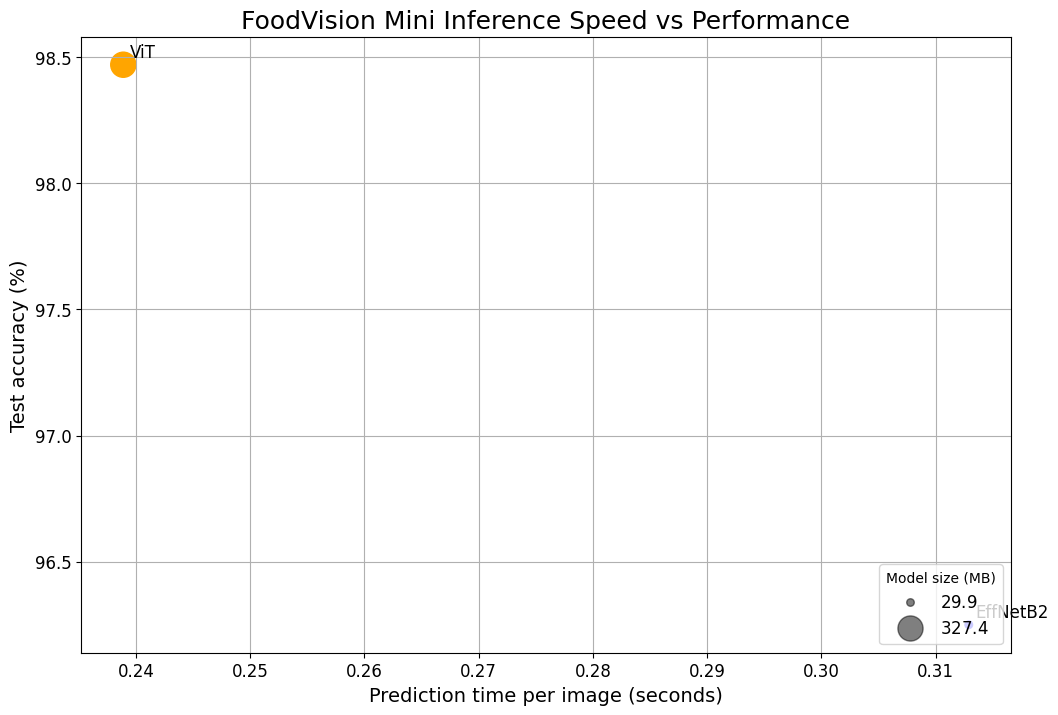

In [100]:
# 1. Create a plot from model comparison DataFrame
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(12, 8))
scatter = ax.scatter(data=df,
                     x="time_per_pred_cpu",
                     y="test_acc",
                     c=["blue", "orange"],
                     s="model_size (MB)")

# 2. Add titles and labels to make our plot look good
ax.set_title("FoodVision Mini Inference Speed vs Performance", fontsize=18)
ax.set_xlabel("Prediction time per image (seconds)", fontsize=14)
ax.set_ylabel("Test accuracy (%)", fontsize=14)
ax.tick_params(axis="both", labelsize=12)
ax.grid(True)

# 3. Annotate the samples on the scatter plot so we know what's going on. 
for index, row in df.iterrows(): 
    ax.annotate(text=row["model"], # note: in some versions of Matplotlib, this may need to be "text" rather than "s"
                xy=(row["time_per_pred_cpu"]+0.0006, row["test_acc"]+0.03),
                size=12)

# 4. Create a legend based on the model sizes (model_size (MB)).
handles, labels = scatter.legend_elements(prop="sizes", alpha=0.5)
model_size_legend = ax.legend(handles,
                              labels,
                              loc="lower right",
                              title="Model size (MB)",
                              fontsize=12)

# Save the figure
plt.savefig("09-foodvision-mini-inference-speed-vs-performance.png")

## 7. Bringing FoodVision Mini to life by creating a Gradio demo

We've chose to deploy EffNetB2 as it fulfills our criteria the best

In [102]:
import gradio as gr

### 7.1 Gradio overview

Gradio helps you create machine learning demos

Why create a demo?

So other people can try our models and we can test them in the real-word

Deployment is as important as training

The overall premise of Gradio is to map inputs -> functions / models -> outputs

### 7.2 Creating a function to map our inputs and outpus

In [104]:
# Put model into CPU
effnetb2 = effnetb2.to("cpu")


# Check device
next(iter(effnetb2.parameters())).device

device(type='cpu')

Let's create a function called `predict()` to go from:
``impages of food -> ML model (EffNetB2) -> output (food class label)``

In [107]:
from typing import Tuple, Dict

def predict(img) -> Tuple[Dict, float]:
    # Start a timer
    start_time = timer()

    # Transform the input image for use with EffNetB2
    img = effnetb2_transforms(img).unsqueeze(0) # unsqueeze = add batch dimension on 0th index

    # Put model into eval mode, make prediction
    effnetb2.eval()
    with torch.inference_mode():
        # Pass transformed image through the model and turn the prediction logits into probaiblities
        pred_probs = torch.softmax(effnetb2(img), dim=1)

    # Create a prediction label and prediction probability dictionary
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

    # Calculate pred time
    end_time = timer()
    pred_time = round(end_time - start_time, 4)

    # Return pred dict and pred time
    return pred_labels_and_probs, pred_time

In [108]:
import random
from PIL import Image 

# Get a list of all test image filepaths
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
print(f"Example test data path: {test_data_paths[0]}")

# Randomly select a test image path
random_image_path = random.sample(test_data_paths, k=1)[0]
random_image_path

# Open the target image
image = Image.open(random_image_path)
print(f"[INFO] Predicting on image at path: {random_image_path}\n")

# Predict on the target image and print out the outputs
pred_dict, pred_time = predict(img=image)
print(pred_dict)
print(pred_time)

Example test data path: data/pizza_steak_sushi_20_percent/test/steak/413497.jpg
[INFO] Predicting on image at path: data/pizza_steak_sushi_20_percent/test/steak/1166047.jpg

{'pizza': 0.23265905678272247, 'steak': 0.7433053851127625, 'sushi': 0.02403555065393448}
3.0455
